In [2]:
!pip install -U rasterio

     |████████████████████████████████| 19.1MB 1.3MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0


In [3]:
import torch
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
import nets
import tests as t
from torchvision import transforms
import random
from PIL import Image
import rasterio
import torchvision.transforms.functional as F
from pathlib import Path


In [4]:
def get_images():
    item = (Path("Bolivia_312675_S1Hand.tif"), Path("Bolivia_312675_LabelHand.tif"))
    base_image = np.nan_to_num(rasterio.open(item[0]).read())
    # Normalize S1 imagery
    base_image = np.clip(base_image, -50, 1)
    base_image = (base_image + 50) / 51

    # Load mask
    mask = rasterio.open(item[1]).read()
    mask[mask == -1] = 255

    im, label = base_image.copy(), mask.copy()
    norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])

    # convert to PIL for easier transforms
    base_im_0 = Image.fromarray(im[0])
    base_im_1 = Image.fromarray(im[1])
    label = Image.fromarray(label.squeeze())

    im = torch.stack(
        [transforms.ToTensor()(np.array(base_im_0)).squeeze(),
          transforms.ToTensor()(np.array(base_im_1)).squeeze()])
    im = norm(im)

    label = transforms.ToTensor()(np.array(label)).squeeze()

    return im, label
get_images()

(tensor([[[ 3.6011,  3.6011,  3.6011,  ...,  2.6859,  2.3968,  1.1980],
          [ 3.6011,  3.6011,  3.6011,  ...,  2.0960,  1.8212,  1.3307],
          [ 3.6011,  3.6011,  3.6011,  ...,  1.4533,  1.2991,  1.2945],
          ...,
          [ 1.2583,  0.7995,  0.6688,  ...,  2.1158,  2.4830,  2.7223],
          [ 1.1117,  0.4231,  0.0988,  ...,  2.1178,  2.1449,  2.0069],
          [ 1.0515,  0.3920,  0.2861,  ...,  2.0036,  1.9130,  1.5182]],
 
         [[ 4.1460,  4.1460,  4.1460,  ...,  0.5528,  0.3152, -0.7499],
          [ 4.1460,  4.1460,  4.1460,  ...,  0.0818, -0.1387, -0.5296],
          [ 4.1460,  4.1460,  4.1460,  ...,  0.2469, -0.2371, -0.6213],
          ...,
          [ 1.8522,  1.9919,  2.0322,  ...,  1.5799,  1.7998,  1.5467],
          [ 1.7174,  1.8234,  1.9076,  ...,  1.1166,  1.6308,  1.6449],
          [ 1.5324,  1.6575,  1.7595,  ...,  1.4546,  1.5237,  1.5643]]]),
 tensor([[255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
      

In [5]:
def load_net(file_path):
    # Load our pretrained net. Depending on type of net we have to do this in different ways, hence the commented portions
    # net = models.segmentation.fcn_resnet50(pretrained=False,
    #                         num_classes=2,
    #                          pretrained_backbone=False)

    # net.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # net = nets.convertBNtoGN(net)

    net = nets.UNET(2, 2)

    # Load saved state dictionary
    net.load_state_dict(torch.load(Path(file_path)))
    # Set net to evaluation mode and transfer it to the graphics card
    net.eval()
    net.to("cuda")
    return net

In [11]:
def create_images():
    net = load_net("S1weak_BCE_unet_0005_bs16_betas2to66_wd0380.pth")
    base, label = get_images()
    # Our nets expect a item of 3 dimensions since we worked in batches, this adds a dummy dimension
    base = base.unsqueeze(dim=0)
    label = label.unsqueeze(dim=0)
    # Send it to the graphics card
    base = base.to("cuda")
    label = label.to("cuda")
    label = label.long()
    # Get a predicted set of water labels from our model
    with torch.no_grad():
        predict = net(base)
        predict = torch.argmax(predict, dim=1)
    # Remove the dummy dimensions
    predict = predict.squeeze(dim=0)
    base = base.squeeze(dim=0)
    label = label.squeeze(dim=0)
    # Convert everything to plottable images
    p = np.uint8(predict.cpu()) * 255
    c1 = np.uint8(base[0, :, :].cpu()) * 255
    c2 = np.uint8(base[1, :, :].cpu()) * 255
    lab = np.uint8(label.cpu()) * 255

    # Make a nice plot showing inputs, predicted output, and provided output
    plt.rcParams["figure.figsize"] = (12, 12)
    fig, ax = plt.subplots(2,2)
    ax[0, 0].imshow(c1, cmap="gist_earth")
    ax[1, 0].imshow(c2, cmap="gist_earth")
    ax[0, 1].imshow(p, cmap="Blues")
    ax[1, 1].imshow(lab, cmap="Blues")

    ax[0, 0].set_title("Original Image Channel 1")
    ax[1, 0].set_title("Original Image Channel 2")
    ax[0, 1].set_title("Predicted Label (ML)")
    #Change this label depending on what type of dataset is being used
    ax[1, 1].set_title("Hand Label")
    fig.suptitle("Bolivia_312675_S1Hand.tif" + "\nIoU: " + str(t.computeIOU(predict, label, argmax=False)))
    plt.show()


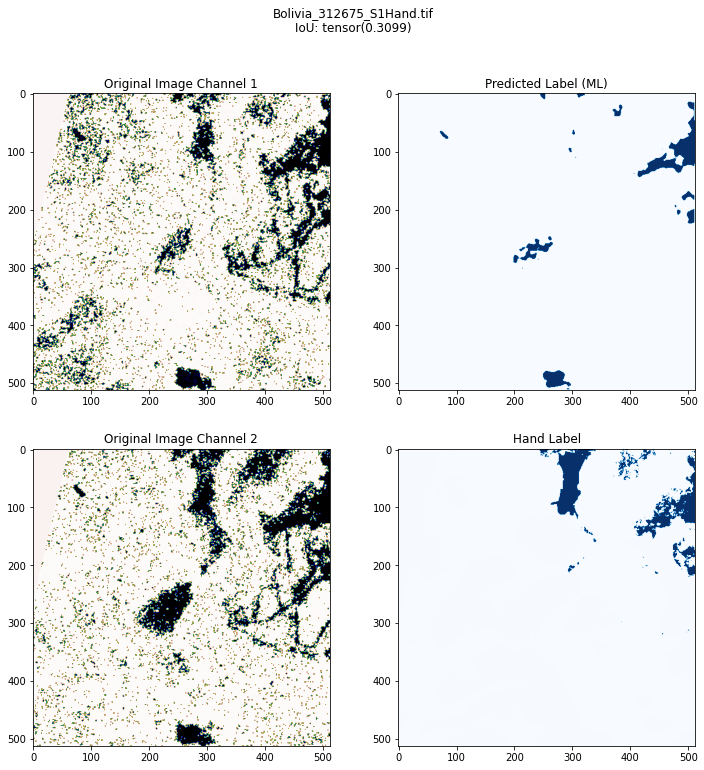

In [12]:
create_images()